In [4]:
from __future__ import print_function
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pdb

In [0]:
class TrainTestUtils(object):

    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.train_min_loss = []
        self.train_max_acc = []
        self.misclassifiedImages = []

    @staticmethod
    def get_device():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        return device

    @staticmethod
    def display_summary(model_obj, input_image_size):
        # model_obj: class objec
        # input_image_size: type int size of the image
        device = TrainTestUtils.get_device()
        print("device")
        model = model_obj.to(device)
        summary(model, input_size=(1, input_image_size, input_image_size))

    @staticmethod
    def get_train_transforms(mean=0.1307, std=0.3081):
        # Train Phase transformations normal
        train_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
            # Note the difference between (0.1307) and (0.1307,)
        ])
        return train_transforms

    @staticmethod
    def get_train_transforms_rotaion(mean=0.1307, std=0.3081):
        # Train Phase transformations with rotation
        train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean,), (std,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])
        return train_transforms

    @staticmethod
    def get_test_transforms(mean=0.1307, std=0.3081):
        # Test Phase transformations
        test_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        return test_transforms


    @staticmethod
    def get_mean_std(path='./data', print_log=False, display_log=True):
        # simple transform
        simple_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        exp = datasets.MNIST(path, train=True, download=True, transform=simple_transforms)
        exp_data = exp.train_data
        exp_data = exp.transform(exp_data.numpy())
        mean = torch.mean(exp_data)
        std =  torch.std(exp_data)
        if display_log:
          print('[Train]')
          print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
          print(' - Tensor Shape:', exp.train_data.size())
          print(' - min:', torch.min(exp_data))
          print(' - max:', torch.max(exp_data))
          print(' - mean:', mean)
          print(' - std:', std)
          print(' - var:', torch.var(exp_data))
        return mean, std

    # First step
    def get_train_test_data_set(self, train_transforms=None, test_transforms=None, path='./data', display_log=False):
        mean, std = TrainTestUtils.get_mean_std(path=path, display_log=display_log)
        if train_transforms is None:
            train_transforms = TrainTestUtils.get_train_transforms_rotaion()
        if test_transforms is None:
            test_transforms = TrainTestUtils.get_test_transforms()
        train = datasets.MNIST(path, train=True, download=True, transform=train_transforms)
        test = datasets.MNIST(path, train=False, download=True, transform=test_transforms)
        return train, test

    
    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

    def train(self, model, device, train_loader, optimizer, epoch, l1_factor=None):
      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        #pdb.set_trace()
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        #update l1 regularizer if requested
        if l1_factor:
          loss = self.apply_l1_regularizer(loss, model, l1_factor)

        self.train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Set: Train Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        acc = float("{:.2f}".format(100*correct/processed))
        #self.train_acc.append(100*correct/processed)
        self.train_acc.append(acc)

    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        self.misclassifiedImages = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                target_change = target.view_as(pred)
                for i in range(len(pred)):
                  if pred[i].item()!= target_change[i].item():
                    self.misclassifiedImages.append([data[i], pred[i], target_change[i]])
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)
        print("Number of miscalssified Images = ",len(self.misclassifiedImages))

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))


    # second step
    def train_test_model(self, model, EPOCHS=20, batch_size=128, path='./data', optimizer=None, train_transforms=None, test_transforms=None, l1_factor=None):
        # Train and test our model
        if optimizer is None:
            optimizer = self.get_optimizer(model, lr=0.01, momentum=0.9)
        train, test =  self.get_train_test_data_set(path=path, train_transforms=train_transforms, test_transforms=test_transforms)
        train_loader, test_loader = self.get_data_loader(train, test, batch_size)
        for epoch in range(1, EPOCHS+1):
            print("EPOCH:", epoch)
            self.train(model, device, train_loader, optimizer, epoch, l1_factor=l1_factor)
            self.test(model, device, test_loader)
            self.train_max_acc.append(self.train_acc[-1])
            self.train_min_loss.append(self.train_losses[-1])

    @staticmethod
    def calculate_diff(train, test):
        zip_obj = zip(train, test)
        diff = [train_i-test_i for train_i, test_i in zip_obj]
        return diff


    def get_optimizer(self, model, lr=0.01, momentum=0.9):
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        return optimizer

    def get_step_optimizer(self, model, lr=0.01, momentum=0.9, step_size=1, gamma=0.1):
       optimizer = self.get_optimizer(model, lr, momentum)
       scheduler = StepLR(optimizer, step_size, gamma)
       return optimizer

    def apply_l1_regularizer(self, loss, model, l1_factor=0.0005):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        parameters = model.parameters()
        for param in parameters:
          reg_loss += torch.sum(param.abs())
          # zero_vector = torch.rand_like(param) * 0
          # reg_loss += l1_crit(param, zero_vector)
        loss += l1_factor * reg_loss
        return loss

    def apply_l2_regularizer(self, model, weight_decay, lr=0.01, momentum=0.9):
        l2_regularizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        return l2_regularizer

    
    def plot_misclassified(self, misclassifiedImages):
      fig = plt.figure(figsize = (10,10))
      for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassifiedImages[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        sub.set_title("Pred={}, Act={}".format(str(misclassifiedImages[i][1].data.cpu().numpy()),str(misclassifiedImages[i][2].data.cpu().numpy())))       
      plt.tight_layout()
      plt.show()

    def plot_test_loss_acc(self,test_losses,test_acc):
      fig, axs = plt.subplots(1,2,figsize=(15,10))
      axs[0].plot(test_losses)
      axs[0].set_title("Test Loss")
      axs[1].plot(test_acc)
      axs[1].set_title("Test Accuracy")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            return False
        except Exception as e:
            pass

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
def norm2d(output_channels, batch_type="BN"):
    if batch_type == "GBN":
        num_splits = 2
        return GhostBatchNorm(output_channels,num_splits)
    else:
        return nn.BatchNorm2d(output_channels)

In [0]:
dropout_value = 0.06

class Net(nn.Module):
    def __init__(self, batch_type="BN"):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value), # output_size = 26
            
        )
      
        self.convblock2 = nn.Sequential(
            
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value), #output_size = 24
            
        )
    
        self.convblock3 = nn.Sequential(
            
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value), #output_size = 22
            
        )

        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 11


        self.convblock4 = nn.Sequential(
          

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value), # output_size = 9   
        )

        

        self.convblock5 = nn.Sequential(   
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), bias=False), 
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value),  # output_size = 7     
            
        )

        self.convblock6 = nn.Sequential(   
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), bias=False), 
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            norm2d(16, batch_type),
            nn.Dropout(dropout_value),   # output_size = 5     
            
        )

        self.convblock7 = nn.Sequential(   
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding = 1,bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            norm2d(16, batch_type),
            nn.Dropout(dropout_value),       # output_size = 5  
            
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5) # output_size = 1*1*16
        ) 


        self.convblock8 = nn.Sequential(   
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1),bias=False), # output_size = 1 * 1* 10
                      
        )




    def forward(self, x):


        x = self.convblock1(x)   
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
#BN WITHOUT L1L2
bn_test_without_L1L2_Loss = []
bn_test_without_L1L2_acc = []
bn_misclassifiedwithoutL1L2= []

#BN WITH L1
bn_test_with_L1_Loss = []
bn_test_with_L1_acc = []
bn_misclassifiedL1 = []

#BN WITH L2
bn_test_with_L2_Loss = []
bn_test_with_L2_acc = []
bn_misclassifiedL2 = []

#BN WITH L1L2
bn_test_with_L1L2_Loss = []
bn_test_with_L1L2_acc = []
bn_misclassifiedL1L2 = []

#GBN WITHOUT L1L2
gbn_test_without_L1L2_Loss = []
gbn_test_without_L1L2_acc = []
gbn_misclassifiedwithoutL1L2 = []

#GBN WITH L1
gbn_test_with_L1_Loss = []
gbn_test_with_L1_acc = []
gbn_misclassifiedL1 = []

#GBN WITH L2
gbn_test_with_L2_Loss = []
gbn_test_with_L2_acc = []
gbn_misclassifiedL2 = []

#GBN WITH L1L2
gbn_test_with_L1L2_Loss = []
gbn_test_with_L1L2_acc = []
gbn_misclassifiedL1L2 = []

EPOCHS = 25
GBN_BATCHSIZE = 64
BN_BATCHSIZE = 32

**GHOST BATCH NORMALISATION**

**GBN WITHOUT L1L2 Loss**

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
    GhostBatchNorm-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,296
              ReLU-6           [-1, 12, 24, 24]               0
    GhostBatchNorm-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
             ReLU-10           [-1, 12, 22, 22]               0
   GhostBatchNorm-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.047891467809677124 Batch_id=937 Accuracy=92.90: 100%|██████████| 938/938 [00:18<00:00, 49.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0510, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Train Set: Train Loss=0.07735975831747055 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:18<00:00, 50.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  96

Test set: Average loss: 0.0325, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Train Set: Train Loss=0.05363196134567261 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:19<00:00, 48.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  96

Test set: Average loss: 0.0316, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Train Set: Train Loss=0.01211334764957428 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:18<00:00, 50.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  116

Test set: Average loss: 0.0364, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Train Set: Train Loss=0.15077915787696838 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:18<00:00, 50.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  73

Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Train Set: Train Loss=0.01307225227355957 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:17<00:00, 52.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  75

Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Train Set: Train Loss=0.2867518365383148 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:18<00:00, 51.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  77

Test set: Average loss: 0.0247, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Train Set: Train Loss=0.09500613063573837 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:17<00:00, 52.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  79

Test set: Average loss: 0.0241, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Train Set: Train Loss=0.004669219255447388 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:17<00:00, 53.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  79

Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Train Set: Train Loss=0.036520346999168396 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:17<00:00, 53.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  57

Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Train Set: Train Loss=0.0037197917699813843 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:17<00:00, 52.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Train Set: Train Loss=0.17497418820858002 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 52.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  78

Test set: Average loss: 0.0230, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Train Set: Train Loss=0.00424647331237793 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:17<00:00, 53.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  68

Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Train Set: Train Loss=0.2821742296218872 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 53.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  77

Test set: Average loss: 0.0222, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Train Set: Train Loss=0.009913116693496704 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 54.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  75

Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Train Set: Train Loss=0.020016133785247803 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:17<00:00, 54.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Train Set: Train Loss=0.01867331564426422 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:17<00:00, 52.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Train Set: Train Loss=0.019818052649497986 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:18<00:00, 51.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  69

Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Train Set: Train Loss=0.002631068229675293 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:17<00:00, 52.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  76

Test set: Average loss: 0.0209, Accuracy: 9924/10000 (99.24%)

EPOCH: 20


Train Set: Train Loss=0.029792428016662598 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:17<00:00, 53.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  70

Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Train Set: Train Loss=0.009133487939834595 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:17<00:00, 53.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Train Set: Train Loss=0.08001644909381866 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:17<00:00, 54.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  55

Test set: Average loss: 0.0201, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Train Set: Train Loss=0.21751773357391357 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:17<00:00, 53.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Train Set: Train Loss=0.022657155990600586 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:16<00:00, 55.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  63

Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 25


Train Set: Train Loss=0.006433799862861633 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:17<00:00, 54.95it/s]


Number of miscalssified Images =  56

Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)



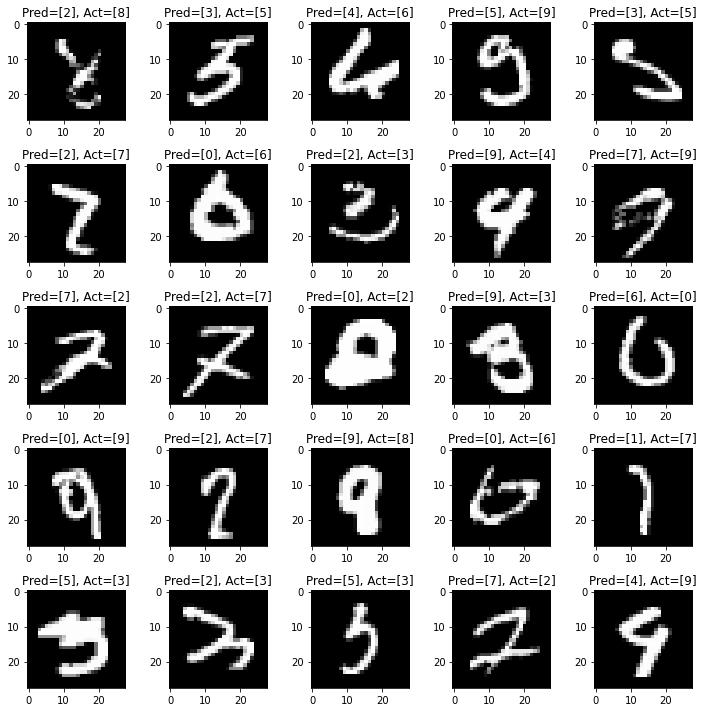

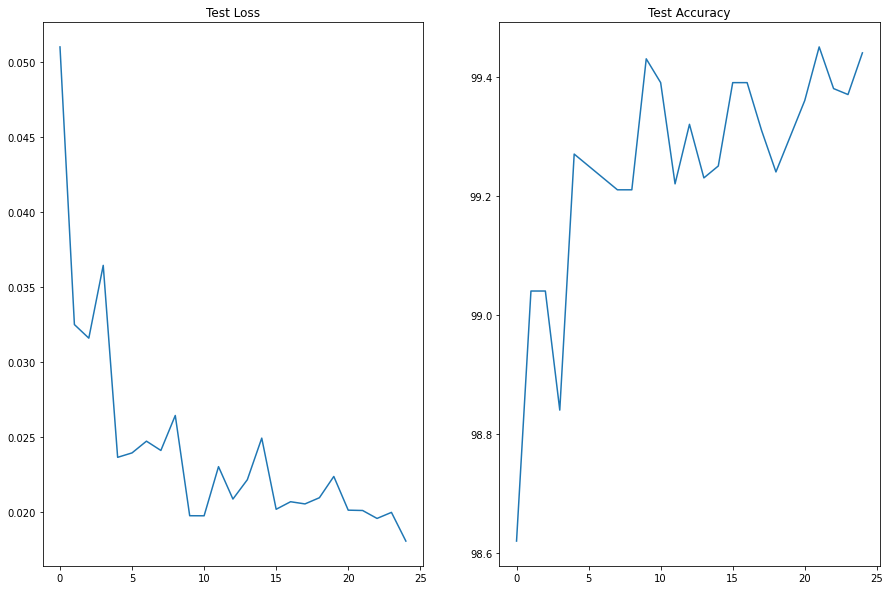

In [11]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE)

    gbn_misclassifiedwithoutL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedwithoutL1L2)

    gbn_test_without_L1L2_Loss.extend(utils_obj.test_losses)
    gbn_test_without_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_without_L1L2_Loss, gbn_test_without_L1L2_acc)

**GBN With L1 Loss**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.3573765158653259 Batch_id=937 Accuracy=90.73: 100%|██████████| 938/938 [00:19<00:00, 48.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  197

Test set: Average loss: 0.0746, Accuracy: 9803/10000 (98.03%)

EPOCH: 2


Train Set: Train Loss=0.32122936844825745 Batch_id=937 Accuracy=97.05: 100%|██████████| 938/938 [00:19<00:00, 49.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  148

Test set: Average loss: 0.0504, Accuracy: 9852/10000 (98.52%)

EPOCH: 3


Train Set: Train Loss=0.24815456569194794 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:18<00:00, 50.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  182

Test set: Average loss: 0.0604, Accuracy: 9818/10000 (98.18%)

EPOCH: 4


Train Set: Train Loss=0.24387329816818237 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:18<00:00, 50.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  158

Test set: Average loss: 0.0560, Accuracy: 9842/10000 (98.42%)

EPOCH: 5


Train Set: Train Loss=0.3925890326499939 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:18<00:00, 50.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  139

Test set: Average loss: 0.0455, Accuracy: 9861/10000 (98.61%)

EPOCH: 6


Train Set: Train Loss=0.2400195300579071 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:18<00:00, 50.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  154

Test set: Average loss: 0.0509, Accuracy: 9846/10000 (98.46%)

EPOCH: 7


Train Set: Train Loss=0.43021249771118164 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:18<00:00, 50.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  142

Test set: Average loss: 0.0494, Accuracy: 9858/10000 (98.58%)

EPOCH: 8


Train Set: Train Loss=0.2527322769165039 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:18<00:00, 49.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  139

Test set: Average loss: 0.0467, Accuracy: 9861/10000 (98.61%)

EPOCH: 9


Train Set: Train Loss=0.20665022730827332 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:19<00:00, 48.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  170

Test set: Average loss: 0.0570, Accuracy: 9830/10000 (98.30%)

EPOCH: 10


Train Set: Train Loss=0.30814117193222046 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:19<00:00, 47.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  121

Test set: Average loss: 0.0379, Accuracy: 9879/10000 (98.79%)

EPOCH: 11


Train Set: Train Loss=0.18995563685894012 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:19<00:00, 47.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  189

Test set: Average loss: 0.0627, Accuracy: 9811/10000 (98.11%)

EPOCH: 12


Train Set: Train Loss=0.4249650835990906 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:19<00:00, 46.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  131

Test set: Average loss: 0.0404, Accuracy: 9869/10000 (98.69%)

EPOCH: 13


Train Set: Train Loss=0.3693552017211914 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:20<00:00, 46.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  149

Test set: Average loss: 0.0472, Accuracy: 9851/10000 (98.51%)

EPOCH: 14


Train Set: Train Loss=0.3620772361755371 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:19<00:00, 48.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  148

Test set: Average loss: 0.0477, Accuracy: 9852/10000 (98.52%)

EPOCH: 15


Train Set: Train Loss=0.23649370670318604 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:19<00:00, 47.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  128

Test set: Average loss: 0.0452, Accuracy: 9872/10000 (98.72%)

EPOCH: 16


Train Set: Train Loss=0.18289215862751007 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:19<00:00, 48.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  148

Test set: Average loss: 0.0449, Accuracy: 9852/10000 (98.52%)

EPOCH: 17


Train Set: Train Loss=0.23931661248207092 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:19<00:00, 48.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0481, Accuracy: 9859/10000 (98.59%)

EPOCH: 18


Train Set: Train Loss=0.17580178380012512 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:18<00:00, 50.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  126

Test set: Average loss: 0.0413, Accuracy: 9874/10000 (98.74%)

EPOCH: 19


Train Set: Train Loss=0.18283291161060333 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:19<00:00, 47.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  156

Test set: Average loss: 0.0548, Accuracy: 9844/10000 (98.44%)

EPOCH: 20


Train Set: Train Loss=0.172065868973732 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:19<00:00, 47.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  140

Test set: Average loss: 0.0433, Accuracy: 9860/10000 (98.60%)

EPOCH: 21


Train Set: Train Loss=0.24146880209445953 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:19<00:00, 47.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  126

Test set: Average loss: 0.0428, Accuracy: 9874/10000 (98.74%)

EPOCH: 22


Train Set: Train Loss=0.19778524339199066 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:20<00:00, 46.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  205

Test set: Average loss: 0.0668, Accuracy: 9795/10000 (97.95%)

EPOCH: 23


Train Set: Train Loss=0.3600620627403259 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:20<00:00, 46.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  111

Test set: Average loss: 0.0397, Accuracy: 9889/10000 (98.89%)

EPOCH: 24


Train Set: Train Loss=0.27882423996925354 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:19<00:00, 46.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0469, Accuracy: 9862/10000 (98.62%)

EPOCH: 25


Train Set: Train Loss=0.20086392760276794 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:20<00:00, 46.86it/s]


Number of miscalssified Images =  146

Test set: Average loss: 0.0480, Accuracy: 9854/10000 (98.54%)



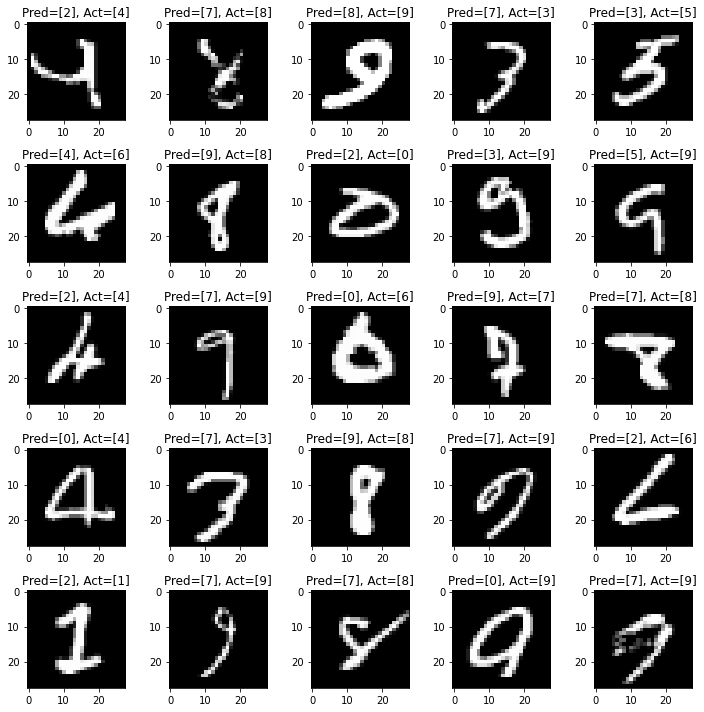

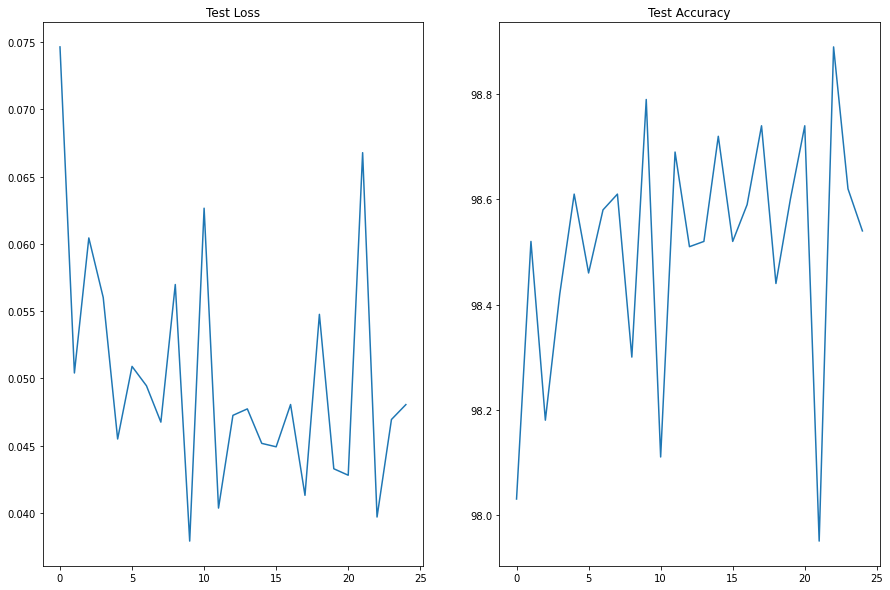

In [12]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, l1_factor=0.0005)

    gbn_misclassifiedL1.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedL1)

    gbn_test_with_L1_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L1_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L1_Loss, gbn_test_with_L1_acc)

**GBN WITH L2**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train Set: Train Loss=0.0994618758559227 Batch_id=937 Accuracy=91.02: 100%|██████████| 938/938 [00:17<00:00, 53.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  135

Test set: Average loss: 0.0575, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Train Set: Train Loss=0.08909498900175095 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:17<00:00, 54.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  126

Test set: Average loss: 0.0516, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Train Set: Train Loss=0.041999831795692444 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:17<00:00, 53.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  121

Test set: Average loss: 0.0581, Accuracy: 9879/10000 (98.79%)

EPOCH: 4


Train Set: Train Loss=0.05148769170045853 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:17<00:00, 53.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  129

Test set: Average loss: 0.0571, Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Train Set: Train Loss=0.1709064394235611 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  119

Test set: Average loss: 0.0497, Accuracy: 9881/10000 (98.81%)

EPOCH: 6


Train Set: Train Loss=0.07990726828575134 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:17<00:00, 52.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  173

Test set: Average loss: 0.0743, Accuracy: 9827/10000 (98.27%)

EPOCH: 7


Train Set: Train Loss=0.1690099984407425 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:17<00:00, 52.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  135

Test set: Average loss: 0.0594, Accuracy: 9865/10000 (98.65%)

EPOCH: 8


Train Set: Train Loss=0.19979003071784973 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:17<00:00, 53.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  170

Test set: Average loss: 0.0678, Accuracy: 9830/10000 (98.30%)

EPOCH: 9


Train Set: Train Loss=0.09299933910369873 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:17<00:00, 53.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  102

Test set: Average loss: 0.0425, Accuracy: 9898/10000 (98.98%)

EPOCH: 10


Train Set: Train Loss=0.07093053311109543 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:17<00:00, 54.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  110

Test set: Average loss: 0.0470, Accuracy: 9890/10000 (98.90%)

EPOCH: 11


Train Set: Train Loss=0.06796287000179291 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:17<00:00, 53.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  142

Test set: Average loss: 0.0628, Accuracy: 9858/10000 (98.58%)

EPOCH: 12


Train Set: Train Loss=0.2210424244403839 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:17<00:00, 52.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  92

Test set: Average loss: 0.0406, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Train Set: Train Loss=0.12028531730175018 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:17<00:00, 52.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  105

Test set: Average loss: 0.0524, Accuracy: 9895/10000 (98.95%)

EPOCH: 14


Train Set: Train Loss=0.40446311235427856 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:17<00:00, 54.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0578, Accuracy: 9859/10000 (98.59%)

EPOCH: 15


Train Set: Train Loss=0.14045999944210052 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:17<00:00, 52.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  124

Test set: Average loss: 0.0494, Accuracy: 9876/10000 (98.76%)

EPOCH: 16


Train Set: Train Loss=0.06190408766269684 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:17<00:00, 54.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  105

Test set: Average loss: 0.0458, Accuracy: 9895/10000 (98.95%)

EPOCH: 17


Train Set: Train Loss=0.07625803351402283 Batch_id=937 Accuracy=98.10: 100%|██████████| 938/938 [00:17<00:00, 53.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  108

Test set: Average loss: 0.0526, Accuracy: 9892/10000 (98.92%)

EPOCH: 18


Train Set: Train Loss=0.09789575636386871 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:17<00:00, 55.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  136

Test set: Average loss: 0.0555, Accuracy: 9864/10000 (98.64%)

EPOCH: 19


Train Set: Train Loss=0.06976862996816635 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:17<00:00, 53.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  95

Test set: Average loss: 0.0446, Accuracy: 9905/10000 (99.05%)

EPOCH: 20


Train Set: Train Loss=0.05930463224649429 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:17<00:00, 53.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  125

Test set: Average loss: 0.0497, Accuracy: 9875/10000 (98.75%)

EPOCH: 21


Train Set: Train Loss=0.1323045790195465 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:17<00:00, 53.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  102

Test set: Average loss: 0.0430, Accuracy: 9898/10000 (98.98%)

EPOCH: 22


Train Set: Train Loss=0.046295009553432465 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:17<00:00, 53.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  107

Test set: Average loss: 0.0485, Accuracy: 9893/10000 (98.93%)

EPOCH: 23


Train Set: Train Loss=0.1692439615726471 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:16<00:00, 55.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  152

Test set: Average loss: 0.0595, Accuracy: 9848/10000 (98.48%)

EPOCH: 24


Train Set: Train Loss=0.08650264889001846 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:17<00:00, 53.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  132

Test set: Average loss: 0.0545, Accuracy: 9868/10000 (98.68%)

EPOCH: 25


Train Set: Train Loss=0.06002349406480789 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:17<00:00, 54.02it/s]


Number of miscalssified Images =  126

Test set: Average loss: 0.0511, Accuracy: 9874/10000 (98.74%)



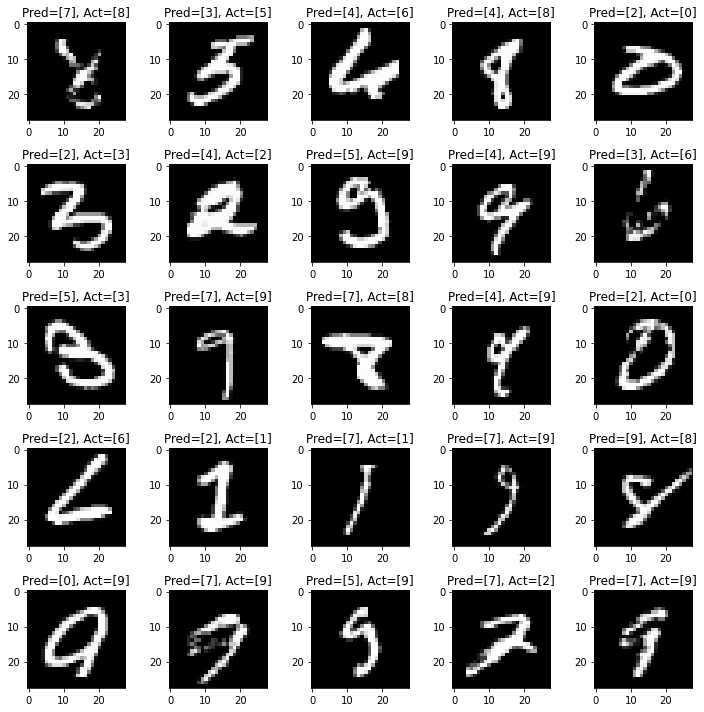

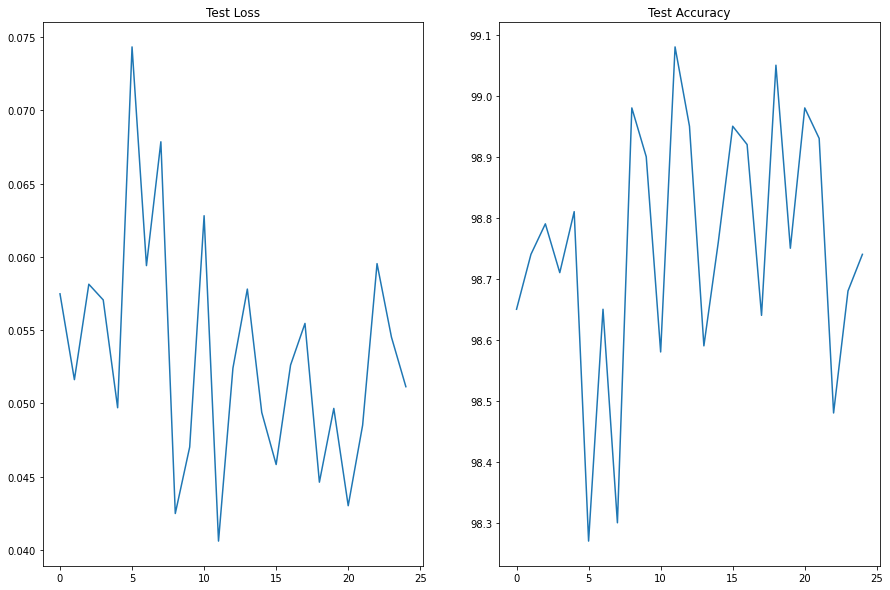

In [13]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, optimizer=l2_regulizer)

    gbn_misclassifiedL2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedL2)

    gbn_test_with_L2_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L2_Loss, gbn_test_with_L2_acc)

**GBN WITH L1L2**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.32310551404953003 Batch_id=937 Accuracy=90.69: 100%|██████████| 938/938 [00:19<00:00, 49.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  195

Test set: Average loss: 0.0847, Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Train Set: Train Loss=0.29147806763648987 Batch_id=937 Accuracy=96.83: 100%|██████████| 938/938 [00:19<00:00, 48.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  218

Test set: Average loss: 0.0816, Accuracy: 9782/10000 (97.82%)

EPOCH: 3


Train Set: Train Loss=0.19754266738891602 Batch_id=937 Accuracy=97.03: 100%|██████████| 938/938 [00:19<00:00, 47.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  194

Test set: Average loss: 0.0843, Accuracy: 9806/10000 (98.06%)

EPOCH: 4


Train Set: Train Loss=0.22297734022140503 Batch_id=937 Accuracy=97.00: 100%|██████████| 938/938 [00:19<00:00, 47.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  237

Test set: Average loss: 0.0958, Accuracy: 9763/10000 (97.63%)

EPOCH: 5


Train Set: Train Loss=0.23439162969589233 Batch_id=937 Accuracy=97.11: 100%|██████████| 938/938 [00:19<00:00, 48.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  220

Test set: Average loss: 0.0832, Accuracy: 9780/10000 (97.80%)

EPOCH: 6


Train Set: Train Loss=0.24522912502288818 Batch_id=937 Accuracy=97.11: 100%|██████████| 938/938 [00:19<00:00, 48.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  245

Test set: Average loss: 0.0939, Accuracy: 9755/10000 (97.55%)

EPOCH: 7


Train Set: Train Loss=0.3448917865753174 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:19<00:00, 48.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  146

Test set: Average loss: 0.0648, Accuracy: 9854/10000 (98.54%)

EPOCH: 8


Train Set: Train Loss=0.36199045181274414 Batch_id=937 Accuracy=97.20: 100%|██████████| 938/938 [00:19<00:00, 48.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  252

Test set: Average loss: 0.0905, Accuracy: 9748/10000 (97.48%)

EPOCH: 9


Train Set: Train Loss=0.46980786323547363 Batch_id=937 Accuracy=97.19: 100%|██████████| 938/938 [00:19<00:00, 48.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  211

Test set: Average loss: 0.0857, Accuracy: 9789/10000 (97.89%)

EPOCH: 10


Train Set: Train Loss=0.22386445105075836 Batch_id=937 Accuracy=97.24: 100%|██████████| 938/938 [00:19<00:00, 48.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  177

Test set: Average loss: 0.0742, Accuracy: 9823/10000 (98.23%)

EPOCH: 11


Train Set: Train Loss=0.2014928162097931 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:19<00:00, 48.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  304

Test set: Average loss: 0.1166, Accuracy: 9696/10000 (96.96%)

EPOCH: 12


Train Set: Train Loss=0.3364468216896057 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:19<00:00, 47.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  165

Test set: Average loss: 0.0766, Accuracy: 9835/10000 (98.35%)

EPOCH: 13


Train Set: Train Loss=0.3652106821537018 Batch_id=937 Accuracy=97.14: 100%|██████████| 938/938 [00:19<00:00, 48.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  339

Test set: Average loss: 0.1309, Accuracy: 9661/10000 (96.61%)

EPOCH: 14


Train Set: Train Loss=0.7497102618217468 Batch_id=937 Accuracy=97.32: 100%|██████████| 938/938 [00:19<00:00, 47.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  457

Test set: Average loss: 0.1623, Accuracy: 9543/10000 (95.43%)

EPOCH: 15


Train Set: Train Loss=0.29571568965911865 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:20<00:00, 46.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  135

Test set: Average loss: 0.0546, Accuracy: 9865/10000 (98.65%)

EPOCH: 16


Train Set: Train Loss=0.20306995511054993 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:19<00:00, 47.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  212

Test set: Average loss: 0.0800, Accuracy: 9788/10000 (97.88%)

EPOCH: 17


Train Set: Train Loss=0.2783969044685364 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:20<00:00, 45.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  255

Test set: Average loss: 0.0996, Accuracy: 9745/10000 (97.45%)

EPOCH: 18


Train Set: Train Loss=0.2501235008239746 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:20<00:00, 45.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  172

Test set: Average loss: 0.0835, Accuracy: 9828/10000 (98.28%)

EPOCH: 19


Train Set: Train Loss=0.23073233664035797 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:20<00:00, 45.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  208

Test set: Average loss: 0.0885, Accuracy: 9792/10000 (97.92%)

EPOCH: 20


Train Set: Train Loss=0.22616443037986755 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:20<00:00, 46.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  284

Test set: Average loss: 0.1073, Accuracy: 9716/10000 (97.16%)

EPOCH: 21


Train Set: Train Loss=0.2634322941303253 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:20<00:00, 46.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  158

Test set: Average loss: 0.0687, Accuracy: 9842/10000 (98.42%)

EPOCH: 22


Train Set: Train Loss=0.2796211838722229 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:20<00:00, 46.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  186

Test set: Average loss: 0.0780, Accuracy: 9814/10000 (98.14%)

EPOCH: 23


Train Set: Train Loss=0.1919262707233429 Batch_id=937 Accuracy=97.43: 100%|██████████| 938/938 [00:20<00:00, 46.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  185

Test set: Average loss: 0.0845, Accuracy: 9815/10000 (98.15%)

EPOCH: 24


Train Set: Train Loss=0.332622766494751 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:19<00:00, 47.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  433

Test set: Average loss: 0.1542, Accuracy: 9567/10000 (95.67%)

EPOCH: 25


Train Set: Train Loss=0.22019487619400024 Batch_id=937 Accuracy=97.29: 100%|██████████| 938/938 [00:20<00:00, 46.47it/s]


Number of miscalssified Images =  213

Test set: Average loss: 0.0788, Accuracy: 9787/10000 (97.87%)



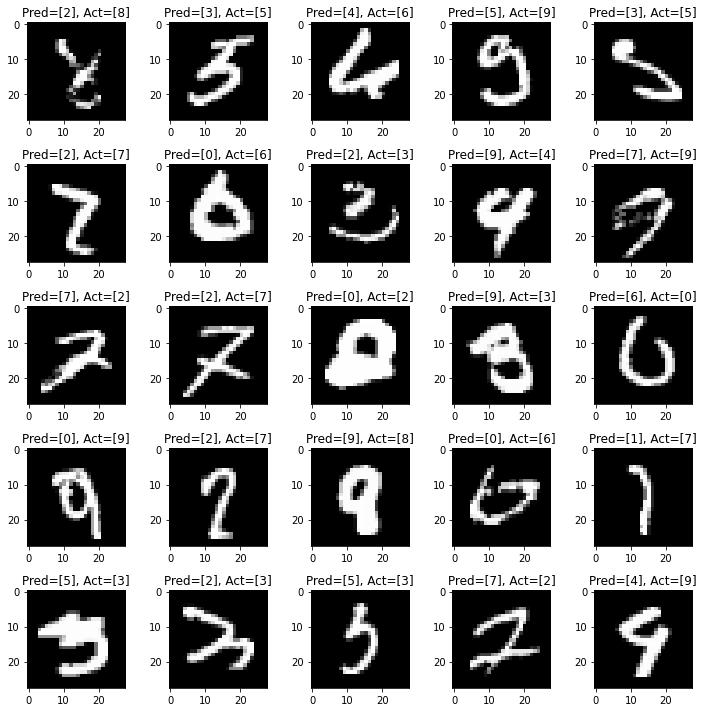

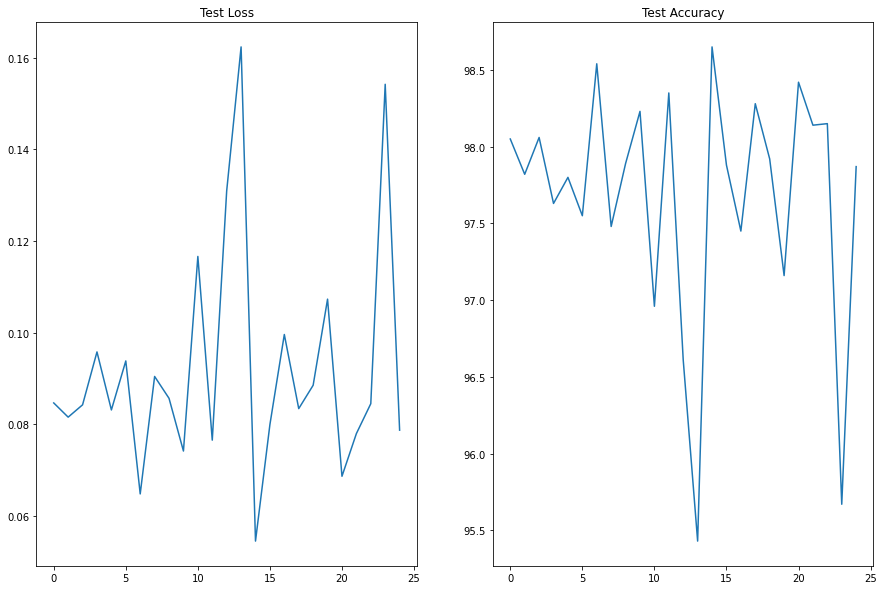

In [14]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, l1_factor=0.0005, optimizer=l2_regulizer)

    gbn_misclassifiedL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedwithoutL1L2)

    gbn_test_with_L1L2_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L1L2_Loss, gbn_test_with_L1L2_acc)

**BATCH NORMALISATION**

**BN WITHOUT L1L2**

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,296
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.06027553975582123 Batch_id=1874 Accuracy=93.39: 100%|██████████| 1875/1875 [00:24<00:00, 75.98it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0445, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Train Set: Train Loss=0.023241668939590454 Batch_id=1874 Accuracy=97.86: 100%|██████████| 1875/1875 [00:24<00:00, 75.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  105

Test set: Average loss: 0.0342, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Train Set: Train Loss=0.020170658826828003 Batch_id=1874 Accuracy=98.28: 100%|██████████| 1875/1875 [00:25<00:00, 74.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  93

Test set: Average loss: 0.0295, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Train Set: Train Loss=0.00608275830745697 Batch_id=1874 Accuracy=98.37: 100%|██████████| 1875/1875 [00:24<00:00, 76.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  78

Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

EPOCH: 5


Train Set: Train Loss=0.20626574754714966 Batch_id=1874 Accuracy=98.53: 100%|██████████| 1875/1875 [00:25<00:00, 74.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  63

Test set: Average loss: 0.0228, Accuracy: 9937/10000 (99.37%)

EPOCH: 6


Train Set: Train Loss=0.007234916090965271 Batch_id=1874 Accuracy=98.71: 100%|██████████| 1875/1875 [00:25<00:00, 74.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  68

Test set: Average loss: 0.0241, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Train Set: Train Loss=0.056111857295036316 Batch_id=1874 Accuracy=98.69: 100%|██████████| 1875/1875 [00:24<00:00, 76.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  65

Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Train Set: Train Loss=0.01223696768283844 Batch_id=1874 Accuracy=98.75: 100%|██████████| 1875/1875 [00:24<00:00, 76.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  75

Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Train Set: Train Loss=0.05207937955856323 Batch_id=1874 Accuracy=98.85: 100%|██████████| 1875/1875 [00:24<00:00, 75.65it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  69

Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Train Set: Train Loss=0.0920044556260109 Batch_id=1874 Accuracy=98.94: 100%|██████████| 1875/1875 [00:24<00:00, 76.97it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  60

Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Train Set: Train Loss=0.004163190722465515 Batch_id=1874 Accuracy=98.95: 100%|██████████| 1875/1875 [00:24<00:00, 77.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0217, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Train Set: Train Loss=0.02145536243915558 Batch_id=1874 Accuracy=98.98: 100%|██████████| 1875/1875 [00:24<00:00, 76.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Train Set: Train Loss=0.005970180034637451 Batch_id=1874 Accuracy=99.01: 100%|██████████| 1875/1875 [00:24<00:00, 77.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  63

Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Train Set: Train Loss=0.09225261211395264 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:24<00:00, 75.50it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  46

Test set: Average loss: 0.0150, Accuracy: 9954/10000 (99.54%)

EPOCH: 15


Train Set: Train Loss=0.18794995546340942 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:25<00:00, 74.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Train Set: Train Loss=0.016790643334388733 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:25<00:00, 73.12it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  52

Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

EPOCH: 17


Train Set: Train Loss=0.02940787374973297 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:27<00:00, 67.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  68

Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Train Set: Train Loss=0.019122019410133362 Batch_id=1874 Accuracy=99.13: 100%|██████████| 1875/1875 [00:28<00:00, 66.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  48

Test set: Average loss: 0.0185, Accuracy: 9952/10000 (99.52%)

EPOCH: 19


Train Set: Train Loss=0.014673799276351929 Batch_id=1874 Accuracy=99.13: 100%|██████████| 1875/1875 [00:28<00:00, 66.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0204, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Train Set: Train Loss=0.006477907299995422 Batch_id=1874 Accuracy=99.13: 100%|██████████| 1875/1875 [00:28<00:00, 66.03it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  60

Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Train Set: Train Loss=0.08516359329223633 Batch_id=1874 Accuracy=99.06: 100%|██████████| 1875/1875 [00:28<00:00, 65.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  56

Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 22


Train Set: Train Loss=0.004504859447479248 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:27<00:00, 67.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  57

Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Train Set: Train Loss=0.03984953463077545 Batch_id=1874 Accuracy=99.17: 100%|██████████| 1875/1875 [00:29<00:00, 64.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  54

Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 24


Train Set: Train Loss=0.0018436163663864136 Batch_id=1874 Accuracy=99.15: 100%|██████████| 1875/1875 [00:27<00:00, 67.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  58

Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Train Set: Train Loss=0.006200969219207764 Batch_id=1874 Accuracy=99.19: 100%|██████████| 1875/1875 [00:28<00:00, 65.98it/s]


Number of miscalssified Images =  52

Test set: Average loss: 0.0194, Accuracy: 9948/10000 (99.48%)



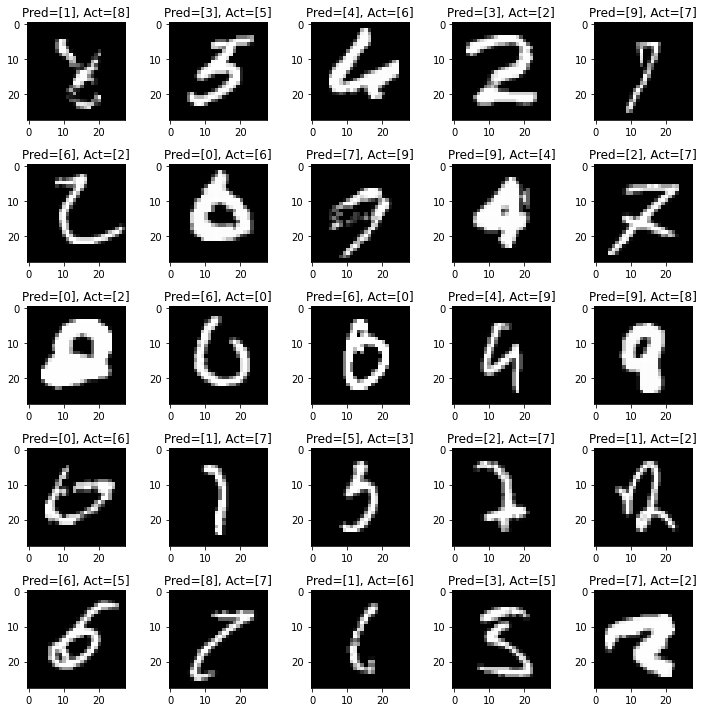

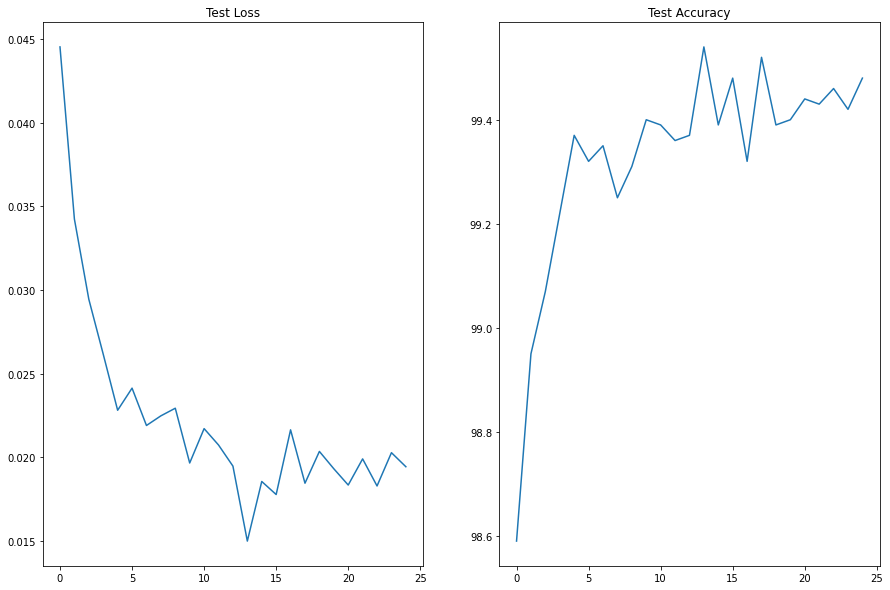

In [15]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE)

    bn_misclassifiedwithoutL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedwithoutL1L2)

    bn_test_without_L1L2_Loss.extend(utils_obj.test_losses)
    bn_test_without_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_without_L1L2_Loss, bn_test_without_L1L2_acc)

**BN WITH L1**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.46520912647247314 Batch_id=1874 Accuracy=92.85: 100%|██████████| 1875/1875 [00:33<00:00, 56.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  197

Test set: Average loss: 0.0629, Accuracy: 9803/10000 (98.03%)

EPOCH: 2


Train Set: Train Loss=0.24779707193374634 Batch_id=1874 Accuracy=96.92: 100%|██████████| 1875/1875 [00:33<00:00, 56.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  174

Test set: Average loss: 0.0589, Accuracy: 9826/10000 (98.26%)

EPOCH: 3


Train Set: Train Loss=0.2348977029323578 Batch_id=1874 Accuracy=97.18: 100%|██████████| 1875/1875 [00:32<00:00, 58.41it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  161

Test set: Average loss: 0.0511, Accuracy: 9839/10000 (98.39%)

EPOCH: 4


Train Set: Train Loss=0.22988605499267578 Batch_id=1874 Accuracy=97.12: 100%|██████████| 1875/1875 [00:31<00:00, 59.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  227

Test set: Average loss: 0.0711, Accuracy: 9773/10000 (97.73%)

EPOCH: 5


Train Set: Train Loss=0.3779738247394562 Batch_id=1874 Accuracy=97.32: 100%|██████████| 1875/1875 [00:31<00:00, 58.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  188

Test set: Average loss: 0.0601, Accuracy: 9812/10000 (98.12%)

EPOCH: 6


Train Set: Train Loss=0.21083223819732666 Batch_id=1874 Accuracy=97.28: 100%|██████████| 1875/1875 [00:31<00:00, 59.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  173

Test set: Average loss: 0.0613, Accuracy: 9827/10000 (98.27%)

EPOCH: 7


Train Set: Train Loss=0.2961309552192688 Batch_id=1874 Accuracy=97.35: 100%|██████████| 1875/1875 [00:31<00:00, 59.15it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0472, Accuracy: 9862/10000 (98.62%)

EPOCH: 8


Train Set: Train Loss=0.3577825129032135 Batch_id=1874 Accuracy=97.23: 100%|██████████| 1875/1875 [00:32<00:00, 58.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  251

Test set: Average loss: 0.0817, Accuracy: 9749/10000 (97.49%)

EPOCH: 9


Train Set: Train Loss=0.27497994899749756 Batch_id=1874 Accuracy=97.33: 100%|██████████| 1875/1875 [00:31<00:00, 60.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  165

Test set: Average loss: 0.0535, Accuracy: 9835/10000 (98.35%)

EPOCH: 10


Train Set: Train Loss=0.41639697551727295 Batch_id=1874 Accuracy=97.34: 100%|██████████| 1875/1875 [00:32<00:00, 58.45it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0491, Accuracy: 9859/10000 (98.59%)

EPOCH: 11


Train Set: Train Loss=0.22803863883018494 Batch_id=1874 Accuracy=97.37: 100%|██████████| 1875/1875 [00:31<00:00, 60.41it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  134

Test set: Average loss: 0.0476, Accuracy: 9866/10000 (98.66%)

EPOCH: 12


Train Set: Train Loss=0.26764219999313354 Batch_id=1874 Accuracy=97.28: 100%|██████████| 1875/1875 [00:31<00:00, 59.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  116

Test set: Average loss: 0.0422, Accuracy: 9884/10000 (98.84%)

EPOCH: 13


Train Set: Train Loss=0.21903380751609802 Batch_id=1874 Accuracy=97.33: 100%|██████████| 1875/1875 [00:31<00:00, 60.03it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  191

Test set: Average loss: 0.0660, Accuracy: 9809/10000 (98.09%)

EPOCH: 14


Train Set: Train Loss=0.418313592672348 Batch_id=1874 Accuracy=97.38: 100%|██████████| 1875/1875 [00:31<00:00, 59.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  193

Test set: Average loss: 0.0652, Accuracy: 9807/10000 (98.07%)

EPOCH: 15


Train Set: Train Loss=0.20217493176460266 Batch_id=1874 Accuracy=97.36: 100%|██████████| 1875/1875 [00:31<00:00, 60.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  133

Test set: Average loss: 0.0431, Accuracy: 9867/10000 (98.67%)

EPOCH: 16


Train Set: Train Loss=0.24140200018882751 Batch_id=1874 Accuracy=97.27: 100%|██████████| 1875/1875 [00:31<00:00, 59.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  201

Test set: Average loss: 0.0609, Accuracy: 9799/10000 (97.99%)

EPOCH: 17


Train Set: Train Loss=0.21071909368038177 Batch_id=1874 Accuracy=97.41: 100%|██████████| 1875/1875 [00:32<00:00, 58.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  116

Test set: Average loss: 0.0439, Accuracy: 9884/10000 (98.84%)

EPOCH: 18


Train Set: Train Loss=0.2017742544412613 Batch_id=1874 Accuracy=97.39: 100%|██████████| 1875/1875 [00:31<00:00, 59.21it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  199

Test set: Average loss: 0.0615, Accuracy: 9801/10000 (98.01%)

EPOCH: 19


Train Set: Train Loss=0.20840947329998016 Batch_id=1874 Accuracy=97.41: 100%|██████████| 1875/1875 [00:32<00:00, 58.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  171

Test set: Average loss: 0.0558, Accuracy: 9829/10000 (98.29%)

EPOCH: 20


Train Set: Train Loss=0.2799761891365051 Batch_id=1874 Accuracy=97.31: 100%|██████████| 1875/1875 [00:31<00:00, 58.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  262

Test set: Average loss: 0.0809, Accuracy: 9738/10000 (97.38%)

EPOCH: 21


Train Set: Train Loss=0.25485438108444214 Batch_id=1874 Accuracy=97.38: 100%|██████████| 1875/1875 [00:32<00:00, 58.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  178

Test set: Average loss: 0.0553, Accuracy: 9822/10000 (98.22%)

EPOCH: 22


Train Set: Train Loss=0.2914336025714874 Batch_id=1874 Accuracy=97.33: 100%|██████████| 1875/1875 [00:31<00:00, 59.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  224

Test set: Average loss: 0.0734, Accuracy: 9776/10000 (97.76%)

EPOCH: 23


Train Set: Train Loss=0.20701183378696442 Batch_id=1874 Accuracy=97.42: 100%|██████████| 1875/1875 [00:31<00:00, 59.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0459, Accuracy: 9859/10000 (98.59%)

EPOCH: 24


Train Set: Train Loss=0.2429242730140686 Batch_id=1874 Accuracy=97.39: 100%|██████████| 1875/1875 [00:31<00:00, 58.60it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  178

Test set: Average loss: 0.0610, Accuracy: 9822/10000 (98.22%)

EPOCH: 25


Train Set: Train Loss=0.25089186429977417 Batch_id=1874 Accuracy=97.36: 100%|██████████| 1875/1875 [00:32<00:00, 58.42it/s]


Number of miscalssified Images =  196

Test set: Average loss: 0.0647, Accuracy: 9804/10000 (98.04%)



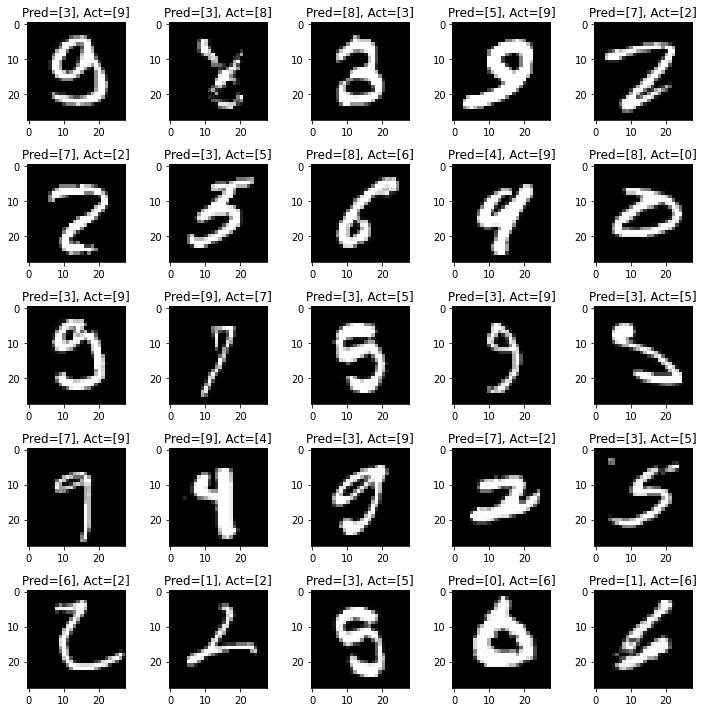

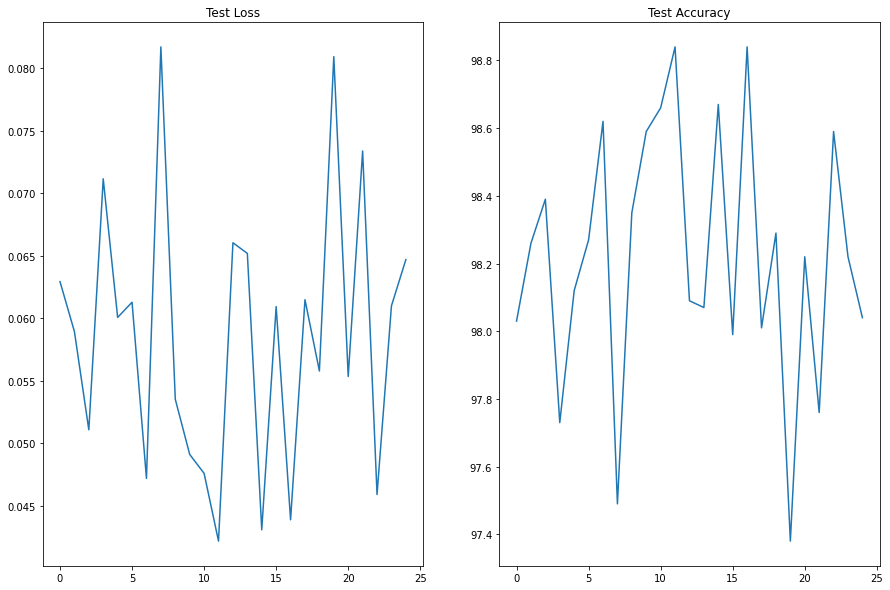

In [16]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, l1_factor=0.0005)

    bn_misclassifiedL1.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedL1)

    bn_test_with_L1_Loss.extend(utils_obj.test_losses)
    bn_test_with_L1_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L1_Loss, bn_test_with_L1_acc)

**BN WITH L2**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train Set: Train Loss=0.06073911488056183 Batch_id=1874 Accuracy=93.28: 100%|██████████| 1875/1875 [00:28<00:00, 65.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  163

Test set: Average loss: 0.0675, Accuracy: 9837/10000 (98.37%)

EPOCH: 2


Train Set: Train Loss=0.08068613708019257 Batch_id=1874 Accuracy=97.15: 100%|██████████| 1875/1875 [00:27<00:00, 67.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  168

Test set: Average loss: 0.0679, Accuracy: 9832/10000 (98.32%)

EPOCH: 3


Train Set: Train Loss=0.23018187284469604 Batch_id=1874 Accuracy=97.40: 100%|██████████| 1875/1875 [00:27<00:00, 67.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  154

Test set: Average loss: 0.0640, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Train Set: Train Loss=0.05222799628973007 Batch_id=1874 Accuracy=97.35: 100%|██████████| 1875/1875 [00:28<00:00, 66.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  144

Test set: Average loss: 0.0627, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Train Set: Train Loss=0.06858552992343903 Batch_id=1874 Accuracy=97.50: 100%|██████████| 1875/1875 [00:27<00:00, 67.30it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  164

Test set: Average loss: 0.0660, Accuracy: 9836/10000 (98.36%)

EPOCH: 6


Train Set: Train Loss=0.03648276627063751 Batch_id=1874 Accuracy=97.50: 100%|██████████| 1875/1875 [00:28<00:00, 66.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  198

Test set: Average loss: 0.0776, Accuracy: 9802/10000 (98.02%)

EPOCH: 7


Train Set: Train Loss=0.17127954959869385 Batch_id=1874 Accuracy=97.60: 100%|██████████| 1875/1875 [00:28<00:00, 66.88it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  137

Test set: Average loss: 0.0571, Accuracy: 9863/10000 (98.63%)

EPOCH: 8


Train Set: Train Loss=0.12179875373840332 Batch_id=1874 Accuracy=97.48: 100%|██████████| 1875/1875 [00:27<00:00, 68.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  219

Test set: Average loss: 0.0782, Accuracy: 9781/10000 (97.81%)

EPOCH: 9


Train Set: Train Loss=0.11394127458333969 Batch_id=1874 Accuracy=97.58: 100%|██████████| 1875/1875 [00:28<00:00, 66.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  172

Test set: Average loss: 0.0671, Accuracy: 9828/10000 (98.28%)

EPOCH: 10


Train Set: Train Loss=0.2284681648015976 Batch_id=1874 Accuracy=97.62: 100%|██████████| 1875/1875 [00:28<00:00, 66.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  158

Test set: Average loss: 0.0727, Accuracy: 9842/10000 (98.42%)

EPOCH: 11


Train Set: Train Loss=0.05250091105699539 Batch_id=1874 Accuracy=97.61: 100%|██████████| 1875/1875 [00:27<00:00, 67.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  294

Test set: Average loss: 0.1028, Accuracy: 9706/10000 (97.06%)

EPOCH: 12


Train Set: Train Loss=0.06710173189640045 Batch_id=1874 Accuracy=97.70: 100%|██████████| 1875/1875 [00:28<00:00, 66.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  129

Test set: Average loss: 0.0562, Accuracy: 9871/10000 (98.71%)

EPOCH: 13


Train Set: Train Loss=0.07717626541852951 Batch_id=1874 Accuracy=97.68: 100%|██████████| 1875/1875 [00:27<00:00, 67.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  211

Test set: Average loss: 0.0823, Accuracy: 9789/10000 (97.89%)

EPOCH: 14


Train Set: Train Loss=0.21336810290813446 Batch_id=1874 Accuracy=97.60: 100%|██████████| 1875/1875 [00:28<00:00, 66.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  260

Test set: Average loss: 0.1006, Accuracy: 9740/10000 (97.40%)

EPOCH: 15


Train Set: Train Loss=0.1327614188194275 Batch_id=1874 Accuracy=97.69: 100%|██████████| 1875/1875 [00:27<00:00, 67.63it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  181

Test set: Average loss: 0.0679, Accuracy: 9819/10000 (98.19%)

EPOCH: 16


Train Set: Train Loss=0.06473565101623535 Batch_id=1874 Accuracy=97.56: 100%|██████████| 1875/1875 [00:27<00:00, 68.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  133

Test set: Average loss: 0.0589, Accuracy: 9867/10000 (98.67%)

EPOCH: 17


Train Set: Train Loss=0.11545750498771667 Batch_id=1874 Accuracy=97.64: 100%|██████████| 1875/1875 [00:27<00:00, 67.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  110

Test set: Average loss: 0.0486, Accuracy: 9890/10000 (98.90%)

EPOCH: 18


Train Set: Train Loss=0.0481216236948967 Batch_id=1874 Accuracy=97.74: 100%|██████████| 1875/1875 [00:27<00:00, 68.63it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  152

Test set: Average loss: 0.0603, Accuracy: 9848/10000 (98.48%)

EPOCH: 19


Train Set: Train Loss=0.05687035620212555 Batch_id=1874 Accuracy=97.58: 100%|██████████| 1875/1875 [00:27<00:00, 67.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  148

Test set: Average loss: 0.0668, Accuracy: 9852/10000 (98.52%)

EPOCH: 20


Train Set: Train Loss=0.10190337896347046 Batch_id=1874 Accuracy=97.62: 100%|██████████| 1875/1875 [00:27<00:00, 67.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  191

Test set: Average loss: 0.0751, Accuracy: 9809/10000 (98.09%)

EPOCH: 21


Train Set: Train Loss=0.12379376590251923 Batch_id=1874 Accuracy=97.56: 100%|██████████| 1875/1875 [00:27<00:00, 67.86it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  151

Test set: Average loss: 0.0625, Accuracy: 9849/10000 (98.49%)

EPOCH: 22


Train Set: Train Loss=0.03890804201364517 Batch_id=1874 Accuracy=97.57: 100%|██████████| 1875/1875 [00:27<00:00, 67.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  164

Test set: Average loss: 0.0665, Accuracy: 9836/10000 (98.36%)

EPOCH: 23


Train Set: Train Loss=0.0334445983171463 Batch_id=1874 Accuracy=97.74: 100%|██████████| 1875/1875 [00:28<00:00, 66.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  162

Test set: Average loss: 0.0651, Accuracy: 9838/10000 (98.38%)

EPOCH: 24


Train Set: Train Loss=0.0904751718044281 Batch_id=1874 Accuracy=97.58: 100%|██████████| 1875/1875 [00:28<00:00, 66.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  135

Test set: Average loss: 0.0565, Accuracy: 9865/10000 (98.65%)

EPOCH: 25


Train Set: Train Loss=0.08300045877695084 Batch_id=1874 Accuracy=97.73: 100%|██████████| 1875/1875 [00:28<00:00, 66.13it/s]


Number of miscalssified Images =  143

Test set: Average loss: 0.0594, Accuracy: 9857/10000 (98.57%)



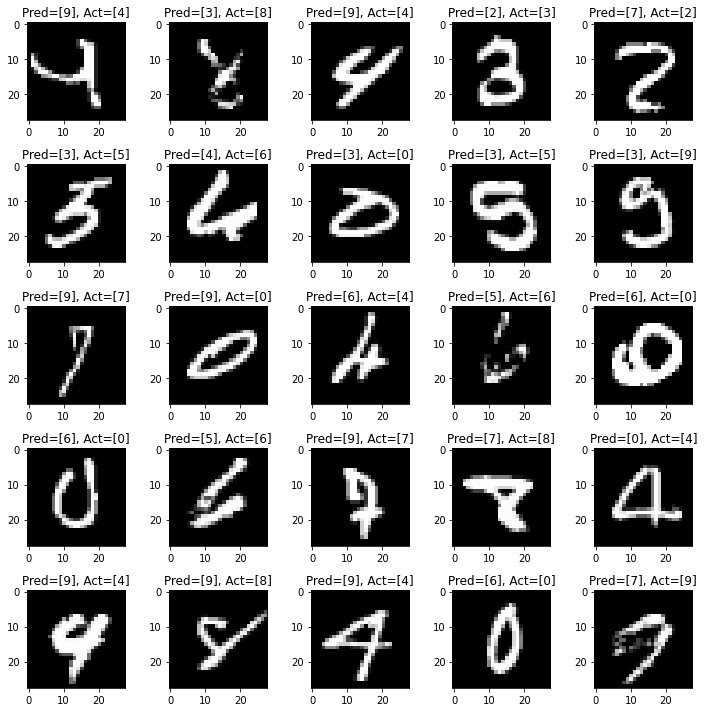

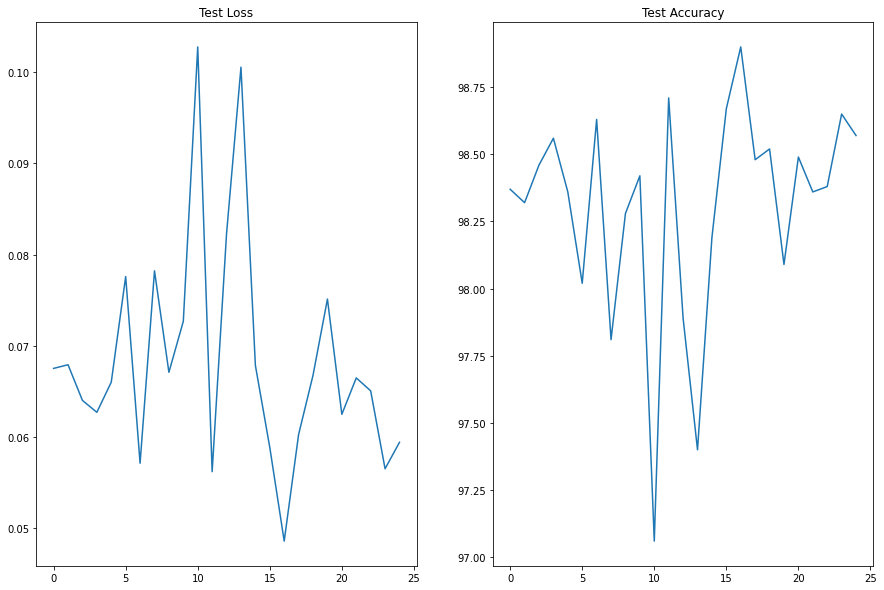

In [17]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, optimizer=l2_regulizer)

    bn_misclassifiedL2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedL2)

    bn_test_with_L2_Loss.extend(utils_obj.test_losses)
    bn_test_with_L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L2_Loss, bn_test_with_L2_acc)

**BN WITH L1L2**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.37852081656455994 Batch_id=1874 Accuracy=92.55: 100%|██████████| 1875/1875 [00:31<00:00, 58.69it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  284

Test set: Average loss: 0.1101, Accuracy: 9716/10000 (97.16%)

EPOCH: 2


Train Set: Train Loss=0.2640891373157501 Batch_id=1874 Accuracy=96.29: 100%|██████████| 1875/1875 [00:32<00:00, 57.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  243

Test set: Average loss: 0.0937, Accuracy: 9757/10000 (97.57%)

EPOCH: 3


Train Set: Train Loss=0.33927637338638306 Batch_id=1874 Accuracy=96.44: 100%|██████████| 1875/1875 [00:33<00:00, 55.69it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  523

Test set: Average loss: 0.1769, Accuracy: 9477/10000 (94.77%)

EPOCH: 4


Train Set: Train Loss=0.208685040473938 Batch_id=1874 Accuracy=96.35: 100%|██████████| 1875/1875 [00:32<00:00, 56.98it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  254

Test set: Average loss: 0.0915, Accuracy: 9746/10000 (97.46%)

EPOCH: 5


Train Set: Train Loss=0.30922865867614746 Batch_id=1874 Accuracy=96.50: 100%|██████████| 1875/1875 [00:32<00:00, 57.74it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  258

Test set: Average loss: 0.1100, Accuracy: 9742/10000 (97.42%)

EPOCH: 6


Train Set: Train Loss=0.23654375970363617 Batch_id=1874 Accuracy=96.49: 100%|██████████| 1875/1875 [00:32<00:00, 57.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  317

Test set: Average loss: 0.1208, Accuracy: 9683/10000 (96.83%)

EPOCH: 7


Train Set: Train Loss=0.38418012857437134 Batch_id=1874 Accuracy=96.55: 100%|██████████| 1875/1875 [00:32<00:00, 57.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  200

Test set: Average loss: 0.0931, Accuracy: 9800/10000 (98.00%)

EPOCH: 8


Train Set: Train Loss=0.29688501358032227 Batch_id=1874 Accuracy=96.51: 100%|██████████| 1875/1875 [00:33<00:00, 56.50it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  455

Test set: Average loss: 0.1598, Accuracy: 9545/10000 (95.45%)

EPOCH: 9


Train Set: Train Loss=0.3252548575401306 Batch_id=1874 Accuracy=96.63: 100%|██████████| 1875/1875 [00:32<00:00, 58.16it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  340

Test set: Average loss: 0.1178, Accuracy: 9660/10000 (96.60%)

EPOCH: 10


Train Set: Train Loss=0.24091403186321259 Batch_id=1874 Accuracy=96.61: 100%|██████████| 1875/1875 [00:31<00:00, 58.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  197

Test set: Average loss: 0.0923, Accuracy: 9803/10000 (98.03%)

EPOCH: 11


Train Set: Train Loss=0.21742722392082214 Batch_id=1874 Accuracy=96.64: 100%|██████████| 1875/1875 [00:31<00:00, 59.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  246

Test set: Average loss: 0.0859, Accuracy: 9754/10000 (97.54%)

EPOCH: 12


Train Set: Train Loss=0.25630781054496765 Batch_id=1874 Accuracy=96.65: 100%|██████████| 1875/1875 [00:32<00:00, 57.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  209

Test set: Average loss: 0.0799, Accuracy: 9791/10000 (97.91%)

EPOCH: 13


Train Set: Train Loss=0.3330498933792114 Batch_id=1874 Accuracy=96.65: 100%|██████████| 1875/1875 [00:32<00:00, 57.54it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  309

Test set: Average loss: 0.1237, Accuracy: 9691/10000 (96.91%)

EPOCH: 14


Train Set: Train Loss=0.4512987732887268 Batch_id=1874 Accuracy=96.64: 100%|██████████| 1875/1875 [00:32<00:00, 56.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  293

Test set: Average loss: 0.1054, Accuracy: 9707/10000 (97.07%)

EPOCH: 15


Train Set: Train Loss=0.3082340359687805 Batch_id=1874 Accuracy=96.56: 100%|██████████| 1875/1875 [00:33<00:00, 55.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  225

Test set: Average loss: 0.0813, Accuracy: 9775/10000 (97.75%)

EPOCH: 16


Train Set: Train Loss=0.3451417088508606 Batch_id=1874 Accuracy=96.71: 100%|██████████| 1875/1875 [00:33<00:00, 56.06it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  320

Test set: Average loss: 0.1179, Accuracy: 9680/10000 (96.80%)

EPOCH: 17


Train Set: Train Loss=0.29530206322669983 Batch_id=1874 Accuracy=96.61: 100%|██████████| 1875/1875 [00:33<00:00, 56.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  161

Test set: Average loss: 0.0668, Accuracy: 9839/10000 (98.39%)

EPOCH: 18


Train Set: Train Loss=0.2163441777229309 Batch_id=1874 Accuracy=96.64: 100%|██████████| 1875/1875 [00:32<00:00, 57.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  219

Test set: Average loss: 0.0880, Accuracy: 9781/10000 (97.81%)

EPOCH: 19


Train Set: Train Loss=0.28516685962677 Batch_id=1874 Accuracy=96.66: 100%|██████████| 1875/1875 [00:33<00:00, 56.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  259

Test set: Average loss: 0.1034, Accuracy: 9741/10000 (97.41%)

EPOCH: 20


Train Set: Train Loss=0.256262868642807 Batch_id=1874 Accuracy=96.56: 100%|██████████| 1875/1875 [00:33<00:00, 55.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  207

Test set: Average loss: 0.0852, Accuracy: 9793/10000 (97.93%)

EPOCH: 21


Train Set: Train Loss=0.2851312756538391 Batch_id=1874 Accuracy=96.67: 100%|██████████| 1875/1875 [00:32<00:00, 57.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  278

Test set: Average loss: 0.1042, Accuracy: 9722/10000 (97.22%)

EPOCH: 22


Train Set: Train Loss=0.19913099706172943 Batch_id=1874 Accuracy=96.65: 100%|██████████| 1875/1875 [00:33<00:00, 56.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  214

Test set: Average loss: 0.0888, Accuracy: 9786/10000 (97.86%)

EPOCH: 23


Train Set: Train Loss=0.18189775943756104 Batch_id=1874 Accuracy=96.69: 100%|██████████| 1875/1875 [00:33<00:00, 56.79it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  280

Test set: Average loss: 0.0988, Accuracy: 9720/10000 (97.20%)

EPOCH: 24


Train Set: Train Loss=0.32772159576416016 Batch_id=1874 Accuracy=96.57: 100%|██████████| 1875/1875 [00:33<00:00, 56.45it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  247

Test set: Average loss: 0.0911, Accuracy: 9753/10000 (97.53%)

EPOCH: 25


Train Set: Train Loss=0.2885000705718994 Batch_id=1874 Accuracy=96.75: 100%|██████████| 1875/1875 [00:33<00:00, 56.49it/s]


Number of miscalssified Images =  219

Test set: Average loss: 0.0900, Accuracy: 9781/10000 (97.81%)



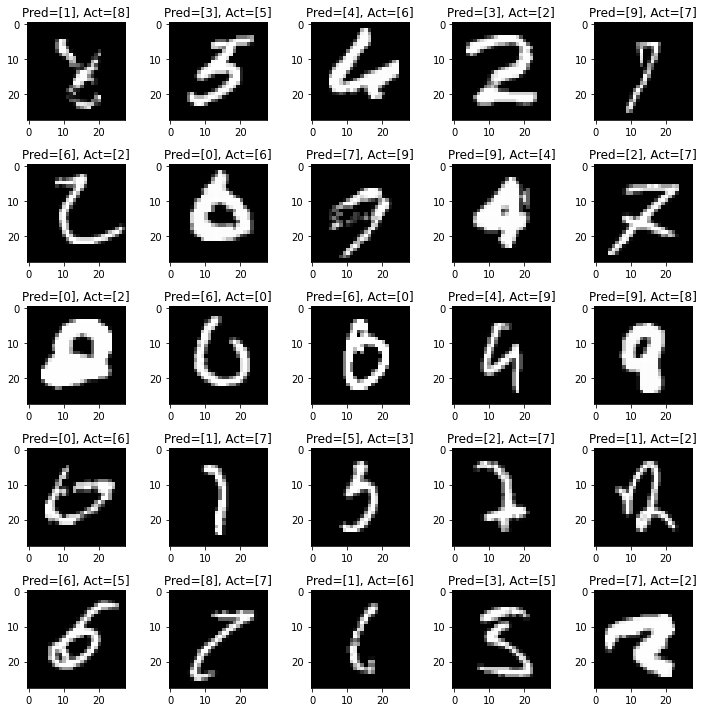

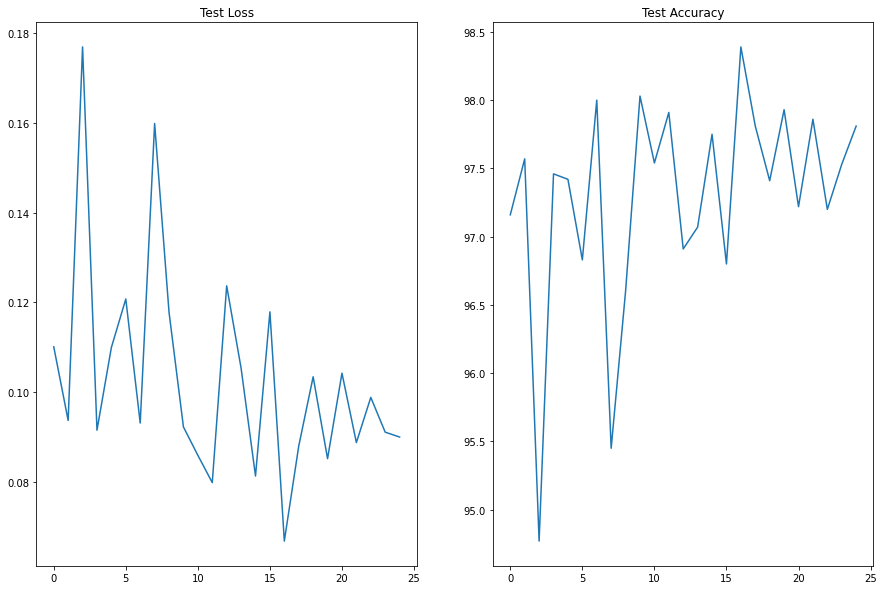

In [18]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, l1_factor=0.0005, optimizer=l2_regulizer)

    bn_misclassifiedL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedwithoutL1L2)

    bn_test_with_L1L2_Loss.extend(utils_obj.test_losses)
    bn_test_with_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L1L2_Loss, bn_test_with_L1L2_acc)

**SHOW LOSS AND ACCURACY GRAPHS**

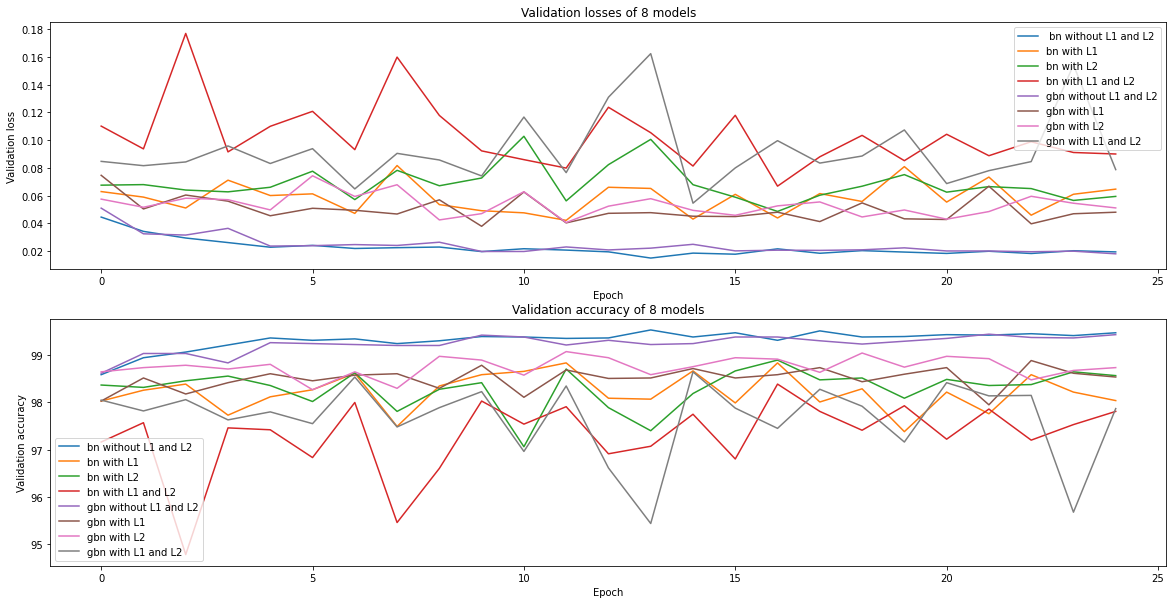

In [27]:
fig, axs = plt.subplots(2,1, figsize=(20,10))
axs[0].plot(bn_test_without_L1L2_Loss, label=' bn without L1 and L2')
axs[0].plot(bn_test_with_L1_Loss, label='bn with L1 ')
axs[0].plot(bn_test_with_L2_Loss, label='bn with L2 ')
axs[0].plot(bn_test_with_L1L2_Loss, label='bn with L1 and L2 ')

axs[0].plot(gbn_test_without_L1L2_Loss, label='gbn without L1 and L2')
axs[0].plot(gbn_test_with_L1_Loss, label='gbn with L1 ')
axs[0].plot(gbn_test_with_L2_Loss, label='gbn with L2 ')
axs[0].plot(gbn_test_with_L1L2_Loss, label='gbn with L1 and L2 ')

axs[0].set(title="Validation losses of 8 models", xlabel="Epoch", ylabel="Validation loss")


axs[0].legend(loc='best')

axs[1].plot(bn_test_without_L1L2_acc, label='bn without L1 and L2')
axs[1].plot(bn_test_with_L1_acc, label='bn with L1 ')
axs[1].plot(bn_test_with_L2_acc, label='bn with L2')
axs[1].plot(bn_test_with_L1L2_acc, label='bn with L1 and L2 ')

axs[1].plot(gbn_test_without_L1L2_acc, label='gbn without L1 and L2')
axs[1].plot(gbn_test_with_L1_acc, label='gbn with L1 ')
axs[1].plot(gbn_test_with_L2_acc, label='gbn with L2')
axs[1].plot(gbn_test_with_L1L2_acc, label='gbn with L1 and L2 ')

axs[1].set(title="Validation accuracy of 8 models", xlabel="Epoch", ylabel="Validation accuracy")
axs[1].legend(loc='best')